## Detecting steric overlap

*Author: Alejandro Corrochano*

Purpose of this notebook is to explain the conducted approach. **.py file** contains the same code. However, if this file wants to be run, it can be done by following these steps:
-  **conda create -n < env_name > scikit-learn jupyter numpy pandas** (creates conda environment with the required packages)
- conda activate < env_name >
- Enter in terminal 'jupyter notebook' (make sure the directory at which this command is executed contains the assignment files)

#### Introduction
When modelling protein, or when docking a pair of proteins together, we might want to test whether our solution is free from steric clashes. That is, when considering atoms to be hard spheres, we want to know whether any atoms are so close together that the spheres representing the atoms intersect in 3-D. Typically we will have one rigid set of atoms and a moving set (e.g. in protein modelling, most of a structure can be rigid while a single side chain is rotated interactively; e.g. in protein docking, one molecule might be fixed while another moved around to achieve a good docking pose).

#### Solution
The proposed solution adopts a machine learning (ML) approach to reduce the number of comparisons needed to estimate collisions. Instead of investigating efficient data structures that can effectively reduce the number of collisions, ML allows further reduction through comparison-free prediction, drastically decreasing the time required to perform the task, which is crucial due to its potential scalability problem. However, this can lead to a slight decrease in accuracy. Therefore, a balance between time and accuracy has to be found according to the needs.

Based on the idea that similar atoms, i.e., close distance in the 3-dimensional space, should behave similarly (collision/non collision), the algorithm works as it follows: A number of atoms are randomly selected to train the predictive model. Their respective labels, 1 if it collides with any atom in the main chain, 0 if it does not, are obtained manually. This means that for each atom randomly chosen for the training set, we iterate through the whole fixed chain to find out of if it collides. Once the model is trained, we apply cross validation for 5 different folds to observe how well it is doing. Lastly, the remaining atoms from the moving chain are predicted. A comparison is later done against the provided test data to evaluate its performance.  

In [1]:
import sys 
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from statistics import mean 

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [2]:
# calculate euclidean distance
def calculate_distance(pt1, pt2):
    return np.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2 +(pt2[2]-pt1[2])**2)

# Gets coordinates of atom 
def get_coordinates(line):
    x = float(line[30:38])
    y = float(line[38:46])
    z = float(line[46:54])

    return (x, y, z)

# Retrieves ATOM and HETATM data from PDB file
def read_data(protein_data):
    atom_array = [line for line in protein_data if line.split(' ')[0] == 'ATOM' or line.split(' ')[0] == 'HETATM']
    return atom_array

# Reads data from test files provided
def read_test_data(test_file):
    file = open(test_file)
    data = [line for line in file]
    collided_atoms = [int(line.split(' ')[0]) for line in data[:-2]]
    num_collisions = len(collided_atoms)
    num_comparisons = int(data[::-1][0].split(' ')[-1])
    file.close()
    return collided_atoms, num_collisions, num_comparisons

# Opens up the PDB file and returns relevant data
def read_proteins(prots):
    ps = []
    for p in prots:
        curated_protein = str(p + '.pdb')
        file = open(curated_protein)
        data = [line.rstrip('\n') for line in file]
        file.close()
        atom_data = read_data(data)
        ps.append(atom_data)

    return ps

# Get labels for randomly selected atoms for the training set
def get_labels(atoms, moving_chain, fixed_chain):
    labels = []
    comparisons = 0
    for indi, atomi in enumerate(atoms):
        collision = False
        for indj, atomj in enumerate(fixed_chain):
            coordsi, coordsj = get_coordinates(moving_chain[atomi]), get_coordinates(atomj)
            distance = calculate_distance(coordsi, coordsj)
            comparisons += 1
            if (distance-4) <= 0:
                labels.append(1)
                collision = True
                break

        if collision == False:
            labels.append(0)
        collision = False

    print('Percentage of maximum total number of comparisons employed: %.2f %% (%d)'
                        %(((comparisons/(len(moving_chain)*len(fixed_chain)))*100), comparisons))
    return labels, comparisons

# 
def get_training_set(num_atoms, moving_chain, fixed_chain):
    random_atoms = np.random.randint(0, len(moving_chain)-1, size = num_atoms)

    # Get the coordinates from each atom
    coordinates = [get_coordinates(moving_chain[atom]) for atom in random_atoms]

    # Create dataframe with coordinates
    df = pd.DataFrame(np.array(coordinates), columns=['x', 'y', 'z'])
    labels, comparisons = get_labels(random_atoms, moving_chain, fixed_chain)
    df['label'] = labels

    return random_atoms, df, comparisons

# Train the model. Returns selected atoms and their labels, trained model, and number of comparisons. 
def train_model(num_samples, moving, fixed):

    # Generate dataframe
    train_atoms, df, comparisons = get_training_set(num_samples, moving, fixed)

    # Build predictive model
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

    #X_train, X_val, y_train, y_val = train_test_split(df[['x','y','z']].values, df['label'], test_size=0.2)
    cv_results = cross_validate(clf, df[['x','y','z']].values, df['label'], cv=5)
    print('Mean accuracy in cross validation:  %.2f' %mean(cv_results['test_score']))

    #Train the model
    clf.fit(df[['x','y','z']].values, df['label'])

    return train_atoms, df['label'], clf, comparisons

# Predict collisions for the remaining atoms in the moving chain.
def predict_collisions(moving_chain, model, train_atoms, train_labels):
    preds = []
    for ind, atom in enumerate(moving_chain):
        # If atom was used for the training, its label is appended to prediction list
        if ind in train_atoms:
            preds.append(train_labels[np.where(train_atoms == ind)[0][0]])
        else:
            coords = get_coordinates(atom)
            prediction = model.predict(np.array(coords).reshape(1, -1))
            preds.append(prediction[0])

    print('Approximated number of collisions:', sum(preds))
    return preds

## Scenario 1: 1CDH (Fixed) - 2CSN(Moving)

In [3]:
fixed_chain, moving_chain = read_proteins(['1cdh', '2csn'])
train_atoms, train_labels, model, comparisons = train_model(250, moving_chain, fixed_chain)

Percentage of maximum total number of comparisons employed: 8.80 % (332546)
Mean accuracy in cross validation:  0.94


#### Predict potential collisions of the rest of atoms, i.e., 2321 atoms

The number of approximated collisions displayed is the result of the ones predicted plus the ones already obtained for the training set. 

In [4]:
predictions = predict_collisions(moving_chain, model, train_atoms, train_labels)

Approximated number of collisions: 827


#### Compare against test data provided

In [5]:
collided_atoms, num_collisions, test_comparisons = read_test_data('1CDH_2CSN.txt')
true_labels = [1 if atom in collided_atoms else 0 for atom in range(len(moving_chain))]

In [6]:
print('Accuracy of predictions %.2f%%' %(accuracy_score(true_labels, predictions)*100))
print('Original number of collisions: %d' %num_collisions)
print('Difference in number of comparisons required: %.2f%%' %(((comparisons - test_comparisons)/test_comparisons)*100))

Accuracy of predictions 88.14%
Original number of collisions: 850
Difference in number of comparisons required: -90.13%


### Conclusions
As can be seen, the accuracy is around 90% and a similar number of collisions have been predicted, which is fairly good considering that a 90% reduction in the number of comparisons has been achieved. Although 250 is the number of training atoms, this could be increased in order to yield better metrics. 

## Scenario 2: 2CSN(Fixed) - 1CDH (Moving) 

In [11]:
fixed_chain, moving_chain = read_proteins(['2csn', '1cdh'])
train_atoms, train_labels, model, comparisons = train_model(250, moving_chain, fixed_chain)

Percentage of maximum total number of comparisons employed: 13.96 % (527258)
Mean accuracy in cross validation:  1.00


#### Predict potential collisions of the rest of atoms, i.e., 1219 atoms

The number of approximated collisions displayed is the result of the ones predicted plus the ones already obtained for the training set. 

In [12]:
predictions = predict_collisions(moving_chain, model, train_atoms, train_labels)

Approximated number of collisions: 616


#### Compare against test data provided

In [13]:
collided_atoms, num_collisions, test_comparisons = read_test_data('2CSN_1CDH.txt')
true_labels = [1 if atom in collided_atoms else 0 for atom in range(len(moving_chain))]

In [14]:
print('Accuracy of predictions %.2f%%' %(accuracy_score(true_labels, predictions)*100))
print('Original number of collisions: %d' %num_collisions)
print('Difference in number of comparisons required: %.2f%%' %(((comparisons - test_comparisons)/test_comparisons)*100))

Accuracy of predictions 95.10%
Original number of collisions: 604
Difference in number of comparisons required: -82.91%


### Conclusions
In this case, 250 is again the number of training atoms. However it represents a bigger size of the chain due to just having 1469 atoms instead of 2571. As it was previously mentioned, a broader representation of the chain in the training set allows generating a more accurate model. With a reduction of approximately 83% in the number of comparisons required, the accuracy is close to 100% and the number of collisions is almost equal.

### Example of .py file run
Note that each time the programme is run, different results may be obtained because no seed is set. The output files will be submitted so that the returned format can be checked.

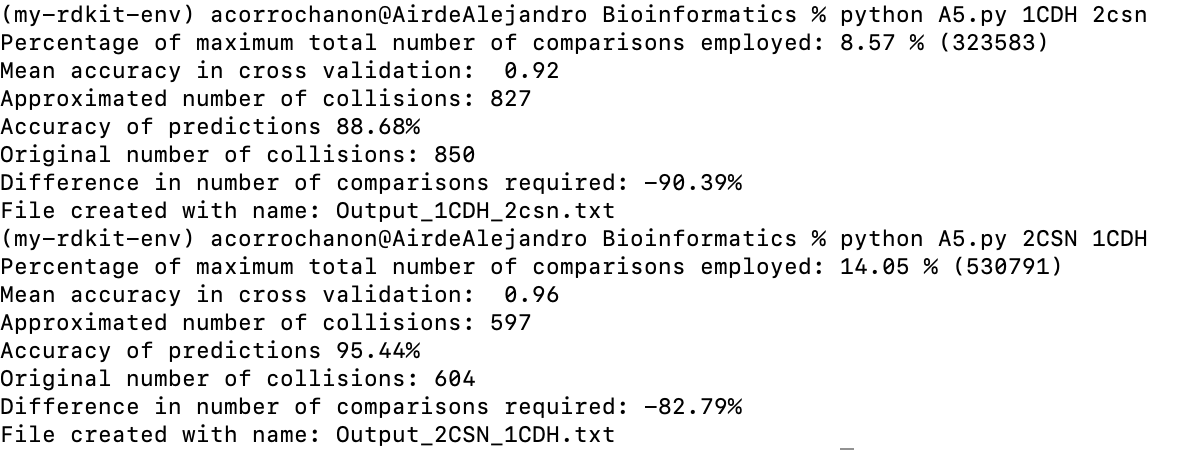